In [103]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from improc import *

In [104]:
ims = []
for i in range(7):
    ims.append(cv2.imread(f'im{i}.jpg',0))
bg = np.mean(np.array(ims),axis=0)

In [105]:
bg = cv2.imread('background.jpg',0)

In [106]:
bg.shape

(1024, 1280)

In [132]:
for i in range(7):
    img = cv2.subtract(ims[i],bg)
    cv2.imwrite(f'im{i}sub.jpg',img)

In [155]:
img = cv2.imread('im0sub.jpg',0)
_,thresh = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)
worm = find_worm_boxes(thresh,buffer=30,brightness=2000)[1][0]

In [186]:
def find_peaks(sum_vec,max_worms=3):
    # Finds local maxima that are high enough to probably be a worm/bright spot
    mu = np.mean(sum_vec)
    sig = np.std(sum_vec)

    peaks = []
    num_worms = 0
    while np.max(sum_vec) > mu+sig and num_worms<max_worms:
        peaks.append(np.argmax(sum_vec))
        low_ind = np.max([0,peaks[-1]-buffer])
        high_ind = np.min([peaks[-1]+buffer,len(sum_vec)])
        sum_vec[low_ind:high_ind] = np.zeros(high_ind-low_ind)
        num_worms+=1
    return peaks

brightness = 2000
buffer = 20
im = img
if len(im.shape)>2:
    im = im[:,:,0]
threshold = 20
ret,thresh = cv2.threshold(im,threshold,255,0)

# First finds proposal spots
peaks_x = find_peaks(np.sum(thresh,axis=0))
peaks_y = find_peaks(np.sum(thresh,axis=1))
p_worms = []
t_worms = []
for i in peaks_x:
    for j in peaks_y:
        p_worms.append(im[int(j-buffer):int(j+buffer+1),int(i-buffer):int(i+buffer+1)])
        # Makes worm box centered on peak brightness with [buffer] pixels on either side.
        t_worms.append(thresh[int(j-buffer):int(j+buffer+1),int(i-buffer):int(i+buffer+1)])
        # Makes thresholded worm box for loc

# Checks proposal boxes and throws out ones that probably don't have worms
worms = []
centers = []
peak_centers = []
for i,worm in enumerate(p_worms):
    if sum(worm.flatten())>brightness: 
        # Saves centers as COM in found box
        sumx,sumy = np.sum(t_worms[i],axis=0)+1e-6,np.sum(t_worms[i],axis=1)+1e-6
        im_sz = buffer*2+1
        centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))
        peak_centers.append(np.array([peaks_x[i//len(peaks_y)],peaks_y[i%len(peaks_y)]]))
        centers[-1] = centers[-1]+peak_centers[-1]-buffer
        worms.append(worm)
# Sort by loc on x axis
if len(centers)>1:
    c_ind = np.argsort(np.array(centers)[:,0]).tolist()
    centers = [x for _,x in sorted(zip(c_ind,centers))]
    peak_centers = [x for _,x in sorted(zip(c_ind,peak_centers))]
    worms = [x for _,x in sorted(zip(c_ind,worms))]


In [187]:
len(worms)

3

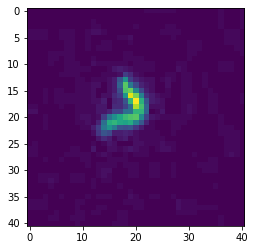

In [190]:
plt.imshow(worms[0])

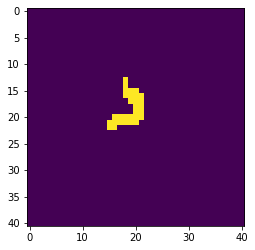

In [285]:
plt.imshow(thresh)

(14.7, 24.599999999999998, -22.45, -12.55)

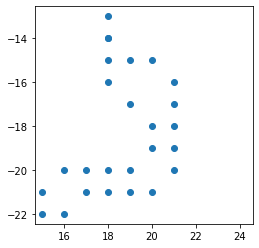

In [287]:
plt.scatter(con[:,0],-con[:,1])
plt.axis('square')

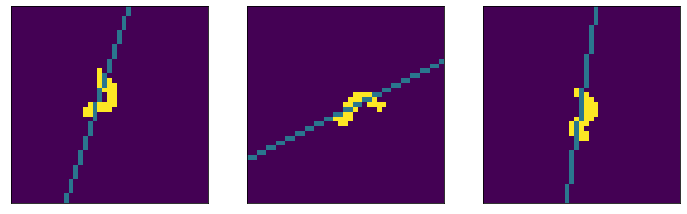

In [304]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches((12,4))
for i in range(3):
    _,thresh = cv2.threshold(worms[i],20,255,cv2.THRESH_BINARY)
    img = thresh
    rows,cols = img.shape
    con, hierarchy = cv2.findContours(thresh,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    con = np.array(con[0]).reshape(-1,2)

    vx,vy,x,y = cv2.fitLine(con, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    img = cv2.line(img,(cols-1,righty),(0,lefty),(100,0,0),1)
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [319]:
np.arctan2(-vy,vx)*180/np.pi

array([82.55654], dtype=float32)

### Evidence I should have done this a long time ago

And Sean is good

#### Fitting a line to contour

In [318]:
#%%timeit
for i in range(3):
    _,thresh = cv2.threshold(worms[i],20,255,cv2.THRESH_BINARY)
    img = thresh
    rows,cols = img.shape
    con, hierarchy = cv2.findContours(thresh,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    con = np.array(con[0]).reshape(-1,2)

    vx,vy,x,y = cv2.fitLine(con, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    img = cv2.line(img,(cols-1,righty),(0,lefty),(100,0,0),1)

#### Template matching

In [292]:
head,bodies = load_templates()

In [300]:
%%timeit
for i in range(1):
    _,thresh = cv2.threshold(worms[i],20,255,cv2.THRESH_BINARY)
    img = thresh
    res = [min(cv2.matchTemplate(img,body,cv2.TM_SQDIFF).flatten()) for body in bodies]
    deg = np.argmin(res) * DEG_INCR *pi/180 # to radians

720 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
